# Exercise VI: Revisiting Linear and Logistic Regression

In the following exercise we will follow an adapted version of [Prof. Tal Yarkoni](https://talyarkoni.org/)'s workshop in  the [NeuroHackademy](https://neurohackademy.org/) 2020 (available [here](https://github.com/neurohackademy/nh2020-curriculum/tree/master/tu-machine-learning-yarkoni)).

Our dataset includes features extracted from the [Autism Brain Imaging Data Exchange II (ABIDE II)](http://fcon_1000.projects.nitrc.org/indi/abide/abide_II.html) project using [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/) (available [here](https://github.com/rb643/Normative_modeling)) <sup>{cite}`richard2019normative`</sup>, as well as some demographic and phenotypic information about the subjects. 

To review the methods discussed in the course so far, we will try and use FreeSurfer's estimated brain features to predict age and Autistic Spectrum Disorder (ASD) diagnosis as a review for both linear and logistic regression (respectively).

## Set up

To read a `.tsv` file we have to specify `delimiter="\t"`:

In [1]:
import pandas as pd

URL = "https://raw.githubusercontent.com/neurohackademy/nh2020-curriculum/master/tu-machine-learning-yarkoni/data/abide2.tsv"
data = pd.read_csv(URL, delimiter="\t")

Never hurts to clean up a little:

In [2]:
IGNORED_COLUMNS = ["age_resid", "sex"]
REPLACE_DICT = {"group": {1: "ASD", 2: "Control"}}

data.drop(columns=IGNORED_COLUMNS, inplace=True)
data.replace(REPLACE_DICT, inplace=True)

## General Inspection

In [3]:
GROUP_COLORS = {"ASD": "purple", "Control": "orange"}

def highlight_group(value: str) -> str:
    try:
        color = GROUP_COLORS[value]        
    except KeyError:
        pass
    else:
        return f"color: {color}"

In [4]:
numeric_data = data.select_dtypes(float)
data.sample(25).style.background_gradient().map(highlight_group, subset="group")

```{margin}
For a useful summary of cortical atlas parcellations in MNI space, including the HCP-MMP1, see [this page](https://www.lead-dbs.org/helpsupport/knowledge-base/atlasesresources/cortical-atlas-parcellations-mni-space/).
```

First thing to note is that we have 1004 observations (subjects) and 1,444 features. 

There are 1,440 features representing four anatomical brain features estimated by FreeSurfer: 
* Surface Area (`fsArea`)
* Volume (`fsVol`)
* Cortical Thickness (`fsCT`)
* [Local Gyrification Index](https://surfer.nmr.mgh.harvard.edu/fswiki/LGI) (`fsLGI`) 

over 360 brain regions of interest (ROIs) as defined by the [Human Connectome Project Multi-Modal Parcellation atlas (HCP-MMP1)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4990127/), as well as:

* `site`: A code representing the site at which the data was acquired.
* `subject`: Subject ID.
* `age`: Age in years.
* `group`: ASD diagnosis (*1=autism, 2=control*).

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Columns: 1444 entries, site to fsCT_R_p24_ROI
dtypes: float64(1441), int64(1), object(2)
memory usage: 11.1+ MB


As expected, all the brain features and the recorded `age` are of type `float`, `subject` is an `int`, and `site` and `group` are categorical (`object`).

## Feature Matrix

Our feature matrix is the same in both regression examples and composed exclusively of FreeSurfer's estimation results of the 360 HCP-MMP1 ROIs: 

In [6]:
X = data.filter(regex="^fs").copy()  # Select columns starting with "fs"
X

fsArea_L_V1_ROI  fsArea_L_MST_ROI  fsArea_L_V6_ROI  fsArea_L_V2_ROI  \
0              2750.0             306.0            354.0           2123.0   
1              2836.0             186.0            354.0           2261.0   
2              3394.0             223.0            373.0           2827.0   
3              3382.0             266.0            422.0           2686.0   
4              3080.0             161.0            346.0           2105.0   
...               ...               ...              ...              ...   
999            3321.0             290.0            381.0           2802.0   
1000           2860.0             162.0            456.0           2460.0   
1001           3377.0             177.0            497.0           2810.0   
1002           3322.0             297.0            426.0           2640.0   
1003           2649.0             140.0            307.0           2359.0   

      fsArea_L_V3_ROI  fsArea_L_V4_ROI  fsArea_L_V8_ROI  fsArea_L_4_ROI  \
0              1451.0           1128.0            269.0          1751.0   
1              1584.0           1241.0            259.0          1521.0   
2              1816.0           1299.0            221.0          1657.0   
3              1893.0           1359.0            234.0          1889.0   
4              1307.0           1004.0            254.0          1334.0   
...               ...              ...              ...             ...   
999            1827.0           1314.0            184.0          1992.0   
1000           1718.0           1225.0            240.0          2459.0   
1001           1866.0           1343.0            254.0          1758.0   
1002           1726.0           1242.0            318.0          1719.0   
1003           1446.0           1003.0            198.0          1807.0   

      fsArea_L_3b_ROI  fsArea_L_FEF_ROI  ...  fsCT_R_p47r_ROI  fsCT_R_TGv_ROI  \
0              1338.0             632.0  ...            3.362           2.827   
1              1105.0             302.0  ...            2.809           3.539   
2              1374.0             456.0  ...            2.435           3.321   
3              1545.0             407.0  ...            3.349           3.344   
4               985.0             315.0  ...            2.428           2.940   
...               ...               ...  ...              ...             ...   
999            1668.0             579.0  ...            2.553           3.502   
1000           1721.0             574.0  ...            2.437           3.658   
1001           1318.0             436.0  ...            2.770           3.422   
1002           1310.0             444.0  ...            2.579           3.328   
1003           1325.0             395.0  ...            3.287           3.170   

      fsCT_R_MBelt_ROI  fsCT_R_LBelt_ROI  fsCT_R_A4_ROI  fsCT_R_STSva_ROI  \
0                2.777             2.526          3.202             3.024   
1                2.944             2.769          3.530             3.079   
2                2.799             2.388          3.148             3.125   
3                2.694             3.030          3.258             2.774   
4                2.809             2.607          3.430             2.752   
...                ...               ...            ...               ...   
999              2.955             2.873          3.074             2.849   
1000             2.537             2.482          3.425             2.819   
1001             2.925             3.028          3.285             2.717   
1002             2.998             3.062          3.601             3.049   
1003             2.494             2.725          3.477             2.850   

      fsCT_R_TE1m_ROI  fsCT_R_PI_ROI  fsCT_R_a32pr_ROI  fsCT_R_p24_ROI  
0               3.354          2.629             2.699           3.179  
1               3.282          2.670             2.746           3.324  
2               3.116          2.891             2.940         

## Target Variables

We will create two vectors for our two target variables, `age` and `asd_diagnosis`:

In [7]:
age = data["age"].copy()
asd_diagnosis = data["group"] == "ASD"

## Train/Test Split

This time, we will put aside 104 observations which will be used as a test dataset after training the model. In addition, 5 cross-validation groups (180 observations in each) will be used to estimate the model with the best performance.

In [8]:
from sklearn.model_selection import train_test_split

TRAIN_SIZE = 900

X_train, X_test, age_train, age_test, asd_diagnosis_train, asd_diagnosis_test = train_test_split(
    X, age, asd_diagnosis, train_size=TRAIN_SIZE, random_state=0)

## Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train.loc[:, :] = scaler.fit_transform(X_train.loc[:, :])
X_test.loc[:, :] = scaler.transform(X_test.loc[:, :])

## Predicting Age

### Model Creation

We will use `sklearn`'s [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) estimator along with the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) class to fine-tune regularization strength by comparing cross-validated models:

In [10]:
import numpy as np

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# This is the base estimator we will use with varying parameter
# values, that will be determined by the parameter grid. 
linear_estimator = Lasso(max_iter=1_000_000)

# Model Configuration
#####################

# Parameter grid of regularization strengths.
ALPHAS = np.logspace(start=-3, stop=0, num=50, endpoint=True)
PARAM_GRID = {"alpha": ALPHAS}


# Search configuration
######################

N_CROSS_VALIDATIONS = 5
# Calculate both R^2 and the nagtive MSE in each iteration of
# the cross-validation.
SCORING = ["r2", "neg_mean_squared_error"]
# Refit the estimator on the whole dataset with the parameter
# setting that has the best cross-validated negative MSE score.
SCORER = "neg_mean_squared_error"
SEARCH_CONFIGURATION = {
    "estimator": linear_estimator,
    "param_grid": PARAM_GRID,
    "scoring": SCORING,
    "refit": SCORER,
    "cv": N_CROSS_VALIDATIONS,
    "n_jobs": 20
}

# GridSearchCV instantiation
linear_model_searcher = GridSearchCV(**SEARCH_CONFIGURATION)

Finally, we are ready to fit our model:

In [11]:
_ = linear_model_searcher.fit(X_train, age_train)

### Model Application

In [12]:
predicted_ages = linear_model_searcher.predict(X_test)

### Model Evaluation

To get the parameters (of the search grid, in our case just $\alpha$ values) of the chosen model:

In [13]:
best_alpha = linear_model_searcher.best_params_["alpha"]
best_alpha

np.float64(0.15998587196060574)

Or, retrieve a report of each iteration over the parameter grid:

In [14]:
linear_search_results = pd.DataFrame(linear_model_searcher.cv_results_)
linear_search_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_alpha  \
0     209.557514     59.457819         0.018029        0.005822     0.001000   
1     270.030131     38.986501         0.020016        0.012679     0.001151   
2     312.694767     53.288542         0.018748        0.016212     0.001326   
3     284.170475     99.641669         0.026277        0.023112     0.001526   
4     248.067160    145.595939         0.010558        0.000603     0.001758   

                             params  split0_test_r2  split1_test_r2  \
0                  {'alpha': 0.001}       -0.500007       -0.136454   
1  {'alpha': 0.0011513953993264468}       -0.486211       -0.123483   
2  {'alpha': 0.0013257113655901094}       -0.474240       -0.111450   
3  {'alpha': 0.0015264179671752333}       -0.451882       -0.094877   
4  {'alpha': 0.0017575106248547913}       -0.413319       -0.078661   

   split2_test_r2  split3_test_r2  ...  std_test_r2  rank_test_r2  \
0       -0.167649       -0.296314  ...     0.147913            50   
1       -0.149179       -0.275396  ...     0.147924            49   
2       -0.130737       -0.249133  ...     0.148699            48   
3       -0.109248       -0.220957  ...     0.146872            47   
4       -0.084382       -0.190203  ...     0.140224            46   

   split0_test_neg_mean_squared_error  split1_test_neg_mean_squared_error  \
0                         -128.996021                          -97.100574   
1                         -127.809618                          -95.992321   
2                         -126.780134                          -94.964207   
3                         -124.857450                          -93.548111   
4                         -121.541144                          -92.162625   

   split2_test_neg_mean_squared_error  split3_test_neg_mean_squared_error  \
0                         -110.616238                         -110.062556   
1                         -108.866508                         -108.286578   
2                         -107.119392                         -106.056740   
3                         -105.083632                         -103.664465   
4                         -102.728003                         -101.053285   

   split4_test_neg_mean_squared_error  mean_test_neg_mean_squared_error  \
0                          -95.429228                       -108.440923   
1                          -94.128585                       -107.016722   
2                          -92.605983                       -105.505291   
3                          -90.960261                       -103.622784   
4                          -88.930457                       -101.283103   

   std_test_neg_mean_squared_error  rank_test_neg_mean_squared_error  
0                        12.064671                                50  
1                        12.041763                                49  
2                        12.108137                                48  
3                        11.957302                                47  
4                        11.386833                                46  

[5 rows x 22 columns]

#### Score

To get the best score (the score of the chosen model):

In [15]:
linear_model_searcher.best_score_

np.float64(-27.403523296133493)

In [16]:
from myst_nb import glue

glue("scorer", SCORER, display=False)

Since we've specified {glue:}`scorer` as the `refit` parameter, the retrieved score indicates the maximal {glue:}`scorer`, or minimal $MSE$ of the chosen model.

Other collected scores (such as $R^2$, in our case) are available in the `cv_results_` dictionary, as demonstrated above.

##### Model Score by $\alpha$

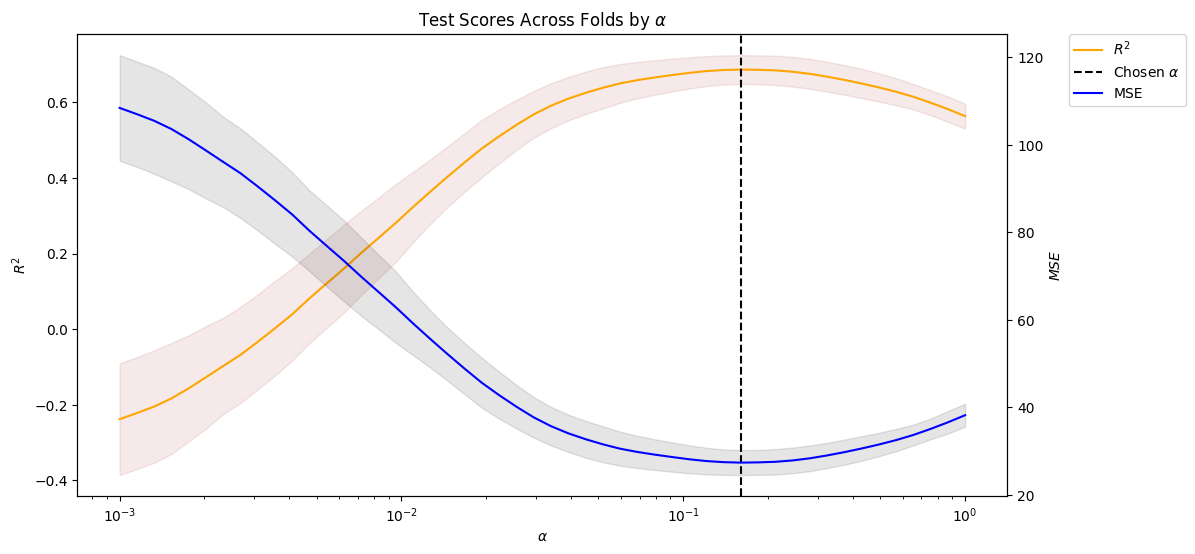

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title(r"Test Scores Across Folds by $\alpha$")

#######
# R^2 #
#######

# Plot mean r2 score
ax.semilogx("param_alpha",
            "mean_test_r2",
            data=linear_search_results,
            label=r"$R^2$",
            color="orange")

# Plot r2 STD across folds
r2_mean = linear_search_results["mean_test_r2"]
r2_std = linear_search_results["std_test_r2"]
r2_lower_limit = r2_mean - r2_std
r2_upper_limit = r2_mean + r2_std
ax.fill_between(ALPHAS,
                r2_lower_limit,
                r2_upper_limit,
                color="brown",
                alpha=0.1)

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$R^2$")

#######
# MSE #
#######

# Convert negative MSE to MSE
mse_mean = -linear_search_results["mean_test_neg_mean_squared_error"]

# Created another Axis instance with a shared X-axis
mse_ax = ax.twinx()

# Plot mean MSE score
mse_ax.semilogx(ALPHAS, mse_mean, label="MSE", color="blue")

# Plot MSE STD across folds
mse_std = linear_search_results["std_test_neg_mean_squared_error"]
mse_lower_limit = mse_mean - mse_std
mse_upper_limit = mse_mean + mse_std
mse_ax.fill_between(ALPHAS,
                    mse_lower_limit,
                    mse_upper_limit,
                    color="black",
                    alpha=0.1)

mse_ax.set_ylabel("$MSE$")

#########
# alpha #
#########

# Chosen alpha
ax.axvline(best_alpha, linestyle="--", color="black", label=r"Chosen $\alpha$")

# Add legend
_ = fig.legend(loc="center", bbox_to_anchor=(1, 0.82))

#### Predicted Values

Visualize predicted values against real values in the test dataset:

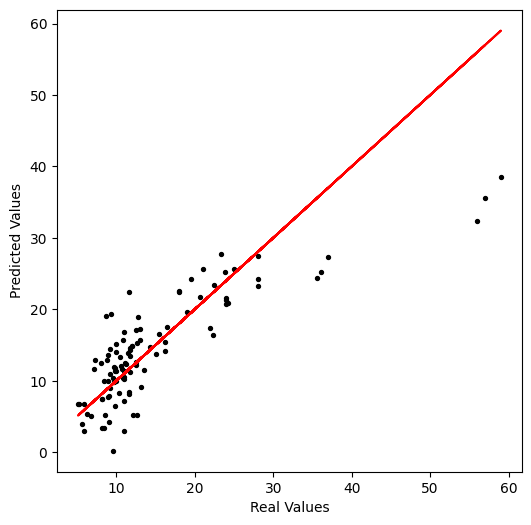

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(age_test, predicted_ages, color="black", s=8)
ax.plot(age_test, age_test, color="red")
ax.set_xlabel("Real Values")
_ = ax.set_ylabel("Predicted Values")

##### Test $R^2$

In [19]:
from sklearn.metrics import r2_score

r2_score(age_test, predicted_ages)

0.688434418043284

##### Test MSE (Mean Squared Prediction Error)

In [20]:
from sklearn.metrics import mean_squared_error

mean_squared_error(age_test, predicted_ages)

30.619466421535076

#### Coefficients

To retrieve the chosen model's coefficients:

In [21]:
coefficients = linear_model_searcher.best_estimator_.coef_
coefficients

array([-0., -0.,  0., ..., -0., -0., -0.], shape=(1440,))

In [22]:
n_coefficients = len(coefficients)
n_selected_coefficients = (coefficients != 0).sum()
n_removed = n_coefficients - n_selected_coefficients

print(
    f"{n_selected_coefficients}/{n_coefficients} features selected ({n_removed} removed)"
)

176/1440 features selected (1264 removed)


The `GridSearchCV` class does not collect all of the coefficients estimated by the generated models. To be able to visualize these changes over our chosen range of regularization strength values ($\alpha$) we would have to manually fit these models and "collect" the coefficient values.

In [ ]:
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(max_iter=1_000_000, cv=N_CROSS_VALIDATIONS)
lasso_coefficient_values = []

for alpha in ALPHAS:
    lasso_model.set_params(alphas=[alpha])
    lasso_model.fit(X_train, age_train)
    lasso_coefficient_values.append(lasso_model.coef_)

lasso_coefficient_values = np.array(lasso_coefficient_values)

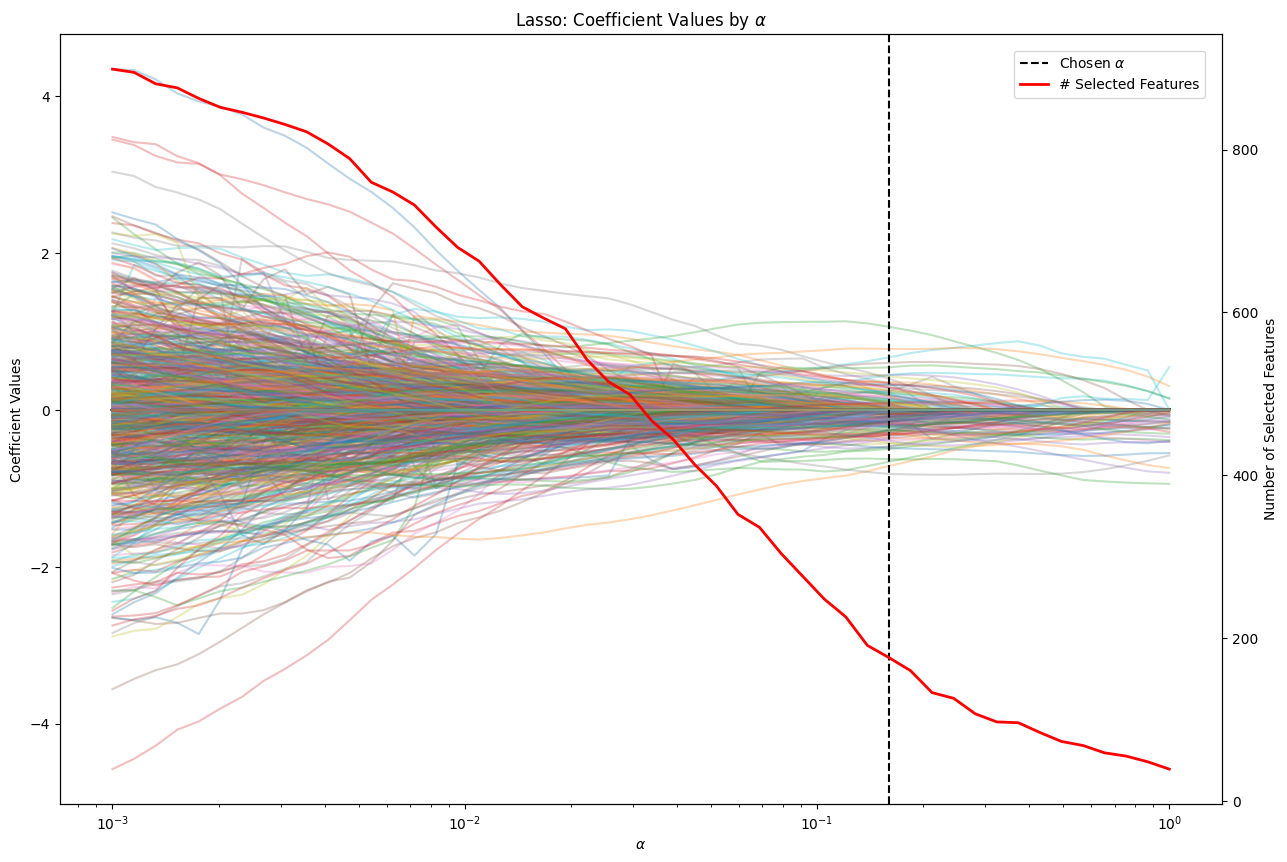

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_title(r"Lasso: Coefficient Values by $\alpha$")

# Coefficient values by alpha
ax.semilogx(ALPHAS, lasso_coefficient_values, alpha=0.3)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("Coefficient Values")

# Number of selected features
n_selected_features = (lasso_coefficient_values != 0).sum(axis=1)
n_features_ax = ax.twinx()
n_features_ax.semilogx(ALPHAS,
                       n_selected_features,
                       color="red",
                       linewidth=2,
                       label="# Selected Features")
n_features_ax.set_ylabel("Number of Selected Features")

# Chosen alpha
ax.axvline(best_alpha, linestyle="--", color="black", label=r"Chosen $\alpha$")

_ = fig.legend(loc="center", bbox_to_anchor=(0.825, 0.84))

Let's create a more convenient table to display the estimated coefficient values:

In [ ]:
MEASUREMENT_DICT = {
    "fsArea": "Surface Area",
    "fsCT": "Cortical Thinkness",
    "fsVol": "Cortical Volume",
    "fsLGI": "Local Gyrification Index"
}
HEMISPHERE_DICT = {"L": "Left", "R": "Right"}
REGION_IDS = range(1, 181)
FEATURE_INDEX = pd.MultiIndex.from_product(
    [HEMISPHERE_DICT.values(), REGION_IDS,
     MEASUREMENT_DICT.values()],
    names=["Hemisphere", "Region ID", "Measurement"])
COLUMN_NAMES = ["Identifier", "Coefficient Value"]


def parse_coefficient_values(X: pd.DataFrame,
                             coefficients: np.ndarray) -> dict:
    feature_info = pd.DataFrame(index=FEATURE_INDEX, columns=COLUMN_NAMES)
    for i, column_name in enumerate(X.columns):
        measurement, hemisphere, identifier, _ = column_name.split("_")
        measurement = MEASUREMENT_DICT.get(measurement)
        hemisphere = HEMISPHERE_DICT.get(hemisphere)
        region_id = i % 180 + 1
        feature_info.loc[(hemisphere, region_id,
                          measurement), :] = identifier, coefficients[i]
    return feature_info


coefficient_values = parse_coefficient_values(X, coefficients)
coefficient_values[coefficient_values["Coefficient Value"] != 0]

Identifier Coefficient Value
Hemisphere Region ID Measurement                                          
Left       6         Cortical Thinkness               V4          0.078542
           7         Cortical Thinkness               V8         -0.047535
                     Cortical Volume                  V8         -0.094691
           8         Surface Area                      4          0.340389
                     Local Gyrification Index          4          0.239352
...                                                  ...               ...
Right      172       Cortical Thinkness              TGv          0.779104
           173       Cortical Thinkness            MBelt         -0.627497
                     Cortical Volume               MBelt         -0.495911
           174       Cortical Thinkness            LBelt          0.288811
           176       Cortical Volume               STSva         -0.289189

[176 rows x 2 columns]

Now we can easily query our calculated coefficients. E.g. to display the features with the largest estimated coefficient values:

In [ ]:
coefficient_values.sort_values("Coefficient Value", ascending=False)

Identifier Coefficient Value
Hemisphere Region ID Measurement                                          
Left       163       Cortical Thinkness              VVC          1.059877
Right      172       Cortical Thinkness              TGv          0.779104
Left       120       Local Gyrification Index          H           0.66935
           136       Cortical Thinkness             TE2p          0.599125
Right      103       Local Gyrification Index         52          0.543951
...                                                  ...               ...
           173       Cortical Volume               MBelt         -0.495911
                     Cortical Thinkness            MBelt         -0.627497
           63        Cortical Volume                 8BM         -0.660464
           52        Cortical Thinkness                2         -0.714349
           168       Cortical Thinkness               Ig         -0.815675

[1440 rows x 2 columns]

Or even better, visualize each measurement's coefficient values in their respective ROIs using [`nilearn`](https://nilearn.github.io/) and [`nibabel`](https://nipy.org/nibabel/):

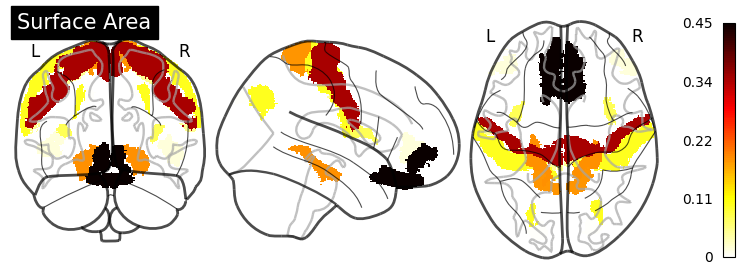

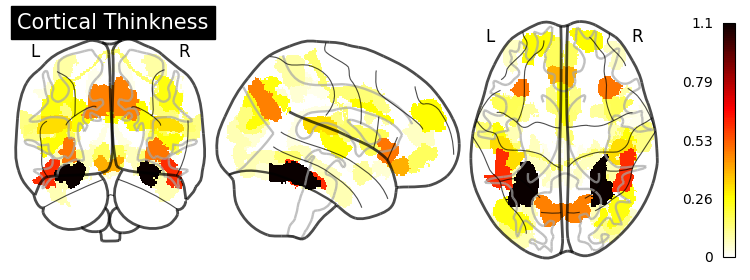

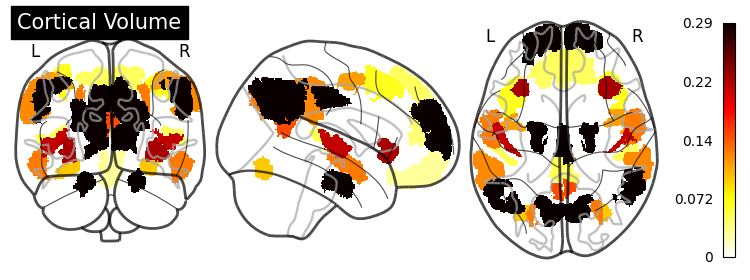

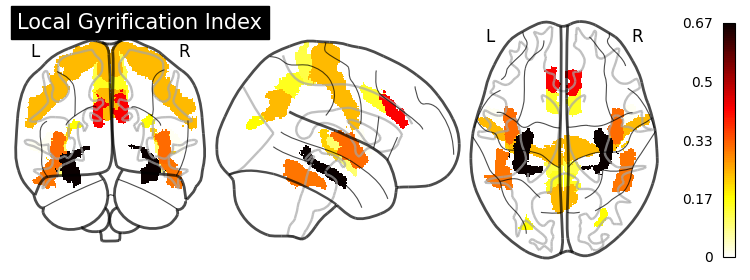

In [ ]:
import nibabel as nib

from nilearn import datasets
from nilearn import plotting
from nilearn import surface
from nilearn.image import new_img_like

HCP_NIFTI_PATH = "HCP-MMP1_on_MNI152_ICBM2009a_nlin.nii.gz"
HCP_IMAGE = nib.load(HCP_NIFTI_PATH)
HCP_DATA = np.round(HCP_IMAGE.get_fdata())


def plot_coefficient_values(coefficient_values: pd.DataFrame,
                            measurement: str) -> None:
    """
    Plots coefficient estimation results using a "glass brain" plot.
    
    Parameters
    ----------
    coefficient_values : pd.DataFrame
        Formatted dataframe containing coefficient values indexed by
        (Hemisphere, Region ID, Measurement)
    measurement: str
        String identifier for the desired type of measurement
    """

    # Create a copy of the HCP-MMP1 atlas array
    template = HCP_DATA.copy()

    # Replace region indices in the template with their matching coefficient values
    for hemisphere in HEMISPHERE_DICT.values():
        # Query appropriate rows
        selection = coefficient_values.xs((hemisphere, measurement),
                                          level=("Hemisphere", "Measurement"))
        # Extract an array of coefficient values
        values = selection["Coefficient Value"].values
        # Replace region indices with values
        for region_id in REGION_IDS:
            template_id = region_id if hemisphere == "Left" else region_id + 180
            template[template == template_id] = values[region_id - 1]

    # Create a `nibabel.nifti1.Nifti1Image` instance for `plot_glass_brain`
    coefficients_nifti = new_img_like(HCP_IMAGE, template, HCP_IMAGE.affine)

    _ = plotting.plot_glass_brain(coefficients_nifti,
                                  display_mode='ortho',
                                  colorbar=True,
                                  title=measurement)


for measurement in MEASUREMENT_DICT.values():
    plot_coefficient_values(coefficient_values, measurement)

## Predicting ASD Diagnosis

We'll use `sklearn`'s [`LogisticRegressionCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) to select a model predicting ASD diagnosis using the provided features.

`LogisticRegressionCV` implements an $\ell_2$ (i.e. "ridge") penalty by default and allows us to easily hypertune our model using a grid of regularization strength values.

### Model Creation

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# The LogisticRegression class uses inverse regularization strength values
Cs = 1 / ALPHAS

logistic_model = LogisticRegressionCV(Cs=Cs,
                                      cv=N_CROSS_VALIDATIONS,
                                      scoring="roc_auc",
                                      max_iter=10_000,
                                      random_state=0)
_ = logistic_model.fit(X_train, asd_diagnosis_train)

### Model Application

In [ ]:
predicted_asd_diagnosis = logistic_model.predict(X_test)

### Model Evaluation

To simply report the selected model's regularization strength and score:

In [ ]:
selected_alpha = 1 / logistic_model.C_[0]
score = logistic_model.score(X_test, asd_diagnosis_test)

print("Selected regularization strength:".ljust(40), f"{selected_alpha:.4f}")
print(f"Score ({logistic_model.scoring}):".ljust(40), f"{score:.4f}")

Selected regularization strength:        1.0000
Score (roc_auc):                         0.6042


#### Confusion Matrix

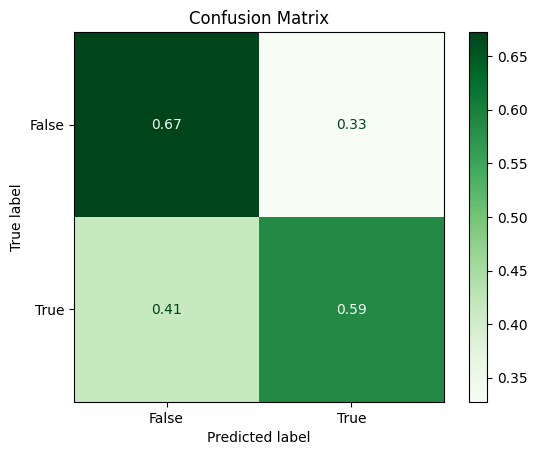

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(logistic_model,
                             X_test,
                             asd_diagnosis_test,
                             cmap=plt.cm.Greens,
                             normalize="true")
_ = disp.ax_.set_title(f"Confusion Matrix")

#### Classification Report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(asd_diagnosis_test, predicted_asd_diagnosis)
print(report)

              precision    recall  f1-score   support

       False       0.67      0.67      0.67        58
        True       0.59      0.59      0.59        46

    accuracy                           0.63       104
   macro avg       0.63      0.63      0.63       104
weighted avg       0.63      0.63      0.63       104



#### ROC-AUC Curve

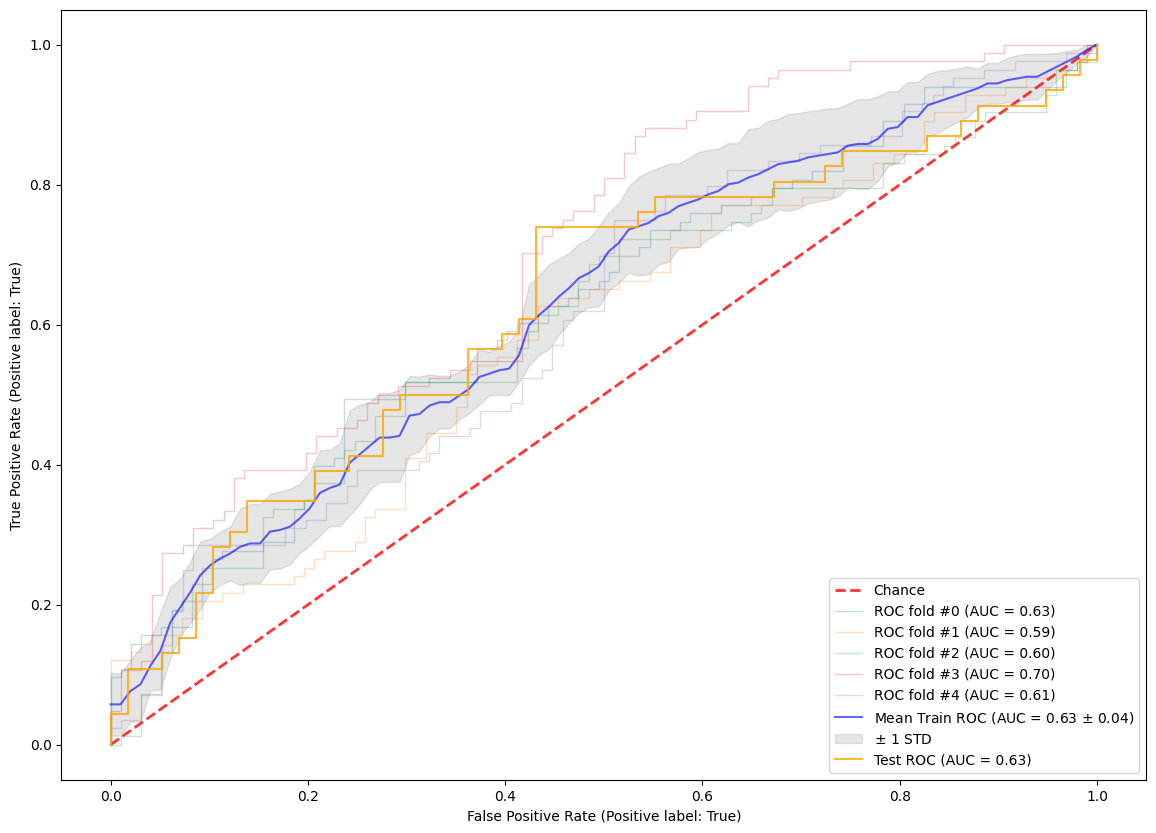

In [ ]:
from sklearn.metrics import auc, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

# Recreate the chosen model's fitting to reproduce ROC curves
# across folds
classifier = LogisticRegression(C=logistic_model.C_[0],
                                max_iter=10_000,
                                random_state=0)
cv = StratifiedKFold(n_splits=N_CROSS_VALIDATIONS,
                     shuffle=True,
                     random_state=0)
cv_splits = cv.split(X_train, asd_diagnosis_train)

# Create a figure
roc_auc_fig, roc_auc_ax = plt.subplots(figsize=(14, 10))

# Plot chance diagonal
roc_auc_ax.plot([0, 1], [0, 1],
                linestyle='--',
                linewidth=2,
                color='red',
                label='Chance',
                alpha=0.8)

#########
# Train #
#########

# Collect values required to plot the mean ROC curve across folds
true_positive_rates = []
auc_scores = []
fpr_values = np.linspace(0, 1, 100)

# Plot each cross-validation fold's ROC curve
for i, (train, test) in enumerate(cv_splits):
    classifier.fit(X_train.iloc[train], asd_diagnosis_train.iloc[train])
    curve_plot = RocCurveDisplay.from_estimator(classifier,
                                                X_train.iloc[test],
                                                asd_diagnosis_train.iloc[test],
                                                name=f"ROC fold #{i}",
                                                alpha=0.25,
                                                linewidth=1,
                                                ax=roc_auc_ax)
    # TPR interpolation
    interp_tpr = np.interp(fpr_values, curve_plot.fpr, curve_plot.tpr, left=0, right=1)
    true_positive_rates.append(interp_tpr)
    # Collect AUC score
    auc_scores.append(curve_plot.roc_auc)

# Calculate AUC mean and STD over folds
mean_tpr = np.mean(true_positive_rates, axis=0)
mean_auc = auc(fpr_values, mean_tpr)
std_auc = np.std(auc_scores)

# Plot mean ROC curve across folds
mean_roc_label = f"Mean Train ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})"
roc_auc_ax.plot(fpr_values,
                mean_tpr,
                color="blue",
                label=mean_roc_label,
                alpha=0.6)

# Plot STD across folds
std_tpr = np.std(true_positive_rates, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
roc_auc_ax.fill_between(fpr_values,
                        tprs_lower,
                        tprs_upper,
                        color='grey',
                        alpha=0.2,
                        label=r'$\pm$ 1 STD')

########
# Test #
########

_ = RocCurveDisplay.from_estimator(classifier,
                                      X_test,
                                      asd_diagnosis_test,
                                      name="Test ROC",
                                      color="orange",
                                      alpha=0.8,
                                      ax=roc_auc_ax)

#### Coefficients

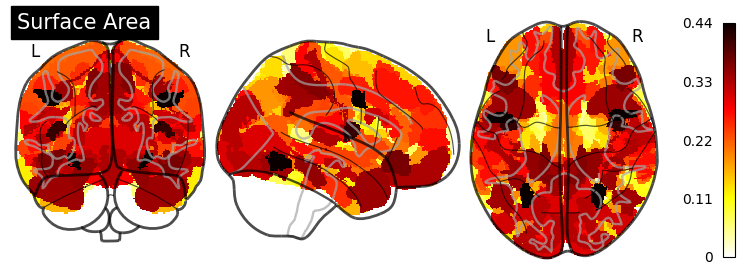

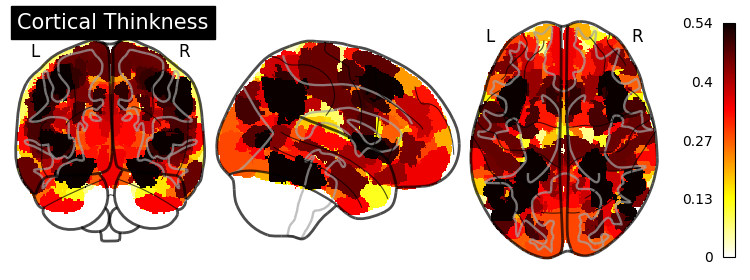

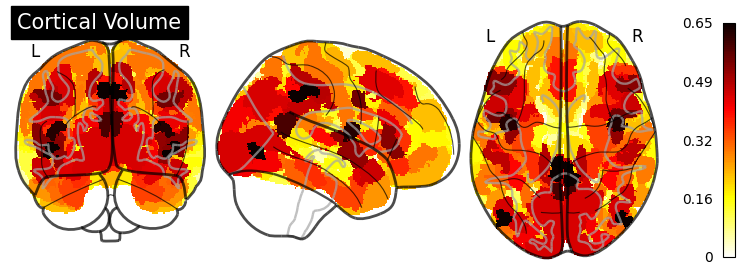

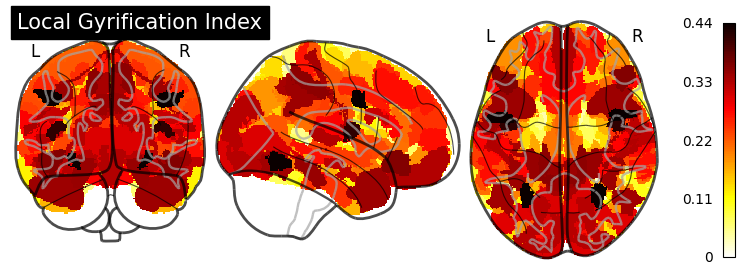

In [ ]:
coefficient_values = parse_coefficient_values(X, logistic_model.coef_.ravel())
for measurement in MEASUREMENT_DICT.values():
    plot_coefficient_values(coefficient_values, measurement)